In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import itertools

from lattice import NuclearLattice
from interactions import get_full_interaction

import data.data
import interactions
import lattice
import importlib
importlib.reload(lattice)
importlib.reload(interactions)
importlib.reload(data.data)

<module 'data.data' from '/n/home10/jmcgreivy/LatticeNuclearModel/data/data.py'>

In [2]:
def get_interactions(a_mm_0, a_mm_1, a_mm_2, a_mm_3, a_mm_4, a_mm_5,
                     a_mp_0, a_mp_1, a_mp_2, a_mp_3, a_mp_4, a_mp_5,
                     a_pm_0, a_pm_1, a_pm_2, a_pm_3, a_pm_4, a_pm_5,
                     a_pp_1, a_pp_2, a_pp_3, a_pp_4, a_pp_5,
                     a_c_1, a_c_2):
    a_pp_0 = a_pp_1
    # Package into lists
    a_list_mm = [a_mm_0, a_mm_1, a_mm_2, a_mm_3, a_mm_4, a_mm_5]
    a_list_mp = [a_mp_0, a_mp_1, a_mp_2, a_mp_3, a_mp_4, a_mp_5]
    a_list_pm = [a_pm_0, a_pm_1, a_pm_2, a_pm_3, a_pm_4, a_pm_5]
    a_list_pp = [a_pp_0, a_pp_1, a_pp_2, a_pp_3, a_pp_4, a_pp_5]
    a_list_coulomb = [a_c_1, a_c_2]
    
    return interactions.get_nuclear_interaction(a_list_mm), interactions.get_nuclear_interaction(a_list_mp), interactions.get_nuclear_interaction(a_list_pm), interactions.get_nuclear_interaction(a_list_pp), interactions.get_coulomb_interaction(a_list_coulomb), interactions.get_full_interaction(a_list_mm, a_list_mp, a_list_pm, a_list_pp, a_list_coulomb)
    

In [5]:
best = {"target": -0.7104369257069676, "params": {"a_c_1": 14.314062519866978, "a_c_2": 9.287014493819653, "a_mm_0": 9.793171371192923, "a_mm_1": -12.69177537374783, "a_mm_2": 6.085627324432591, "a_mm_3": -4.276774691407831, "a_mm_4": 9.235474926090182, "a_mm_5": -6.24563694791305, "a_mp_0": 0.19546680218673923, "a_mp_1": 8.986943243301976, "a_mp_2": -2.9435487523757073, "a_mp_3": -1.6023932656259268, "a_mp_4": 4.471500578834809, "a_mp_5": 9.630883506982038, "a_pm_0": -19.916404730033573, "a_pm_1": -0.9333676017232828, "a_pm_2": 8.92098846822973, "a_pm_3": -15.602573158101695, "a_pm_4": 6.574733075481743, "a_pm_5": -9.62635571433258, "a_pp_1": 9.383624671773303, "a_pp_2": 9.99999999937678, "a_pp_3": 7.32344132269273, "a_pp_4": 1.8055090383790153, "a_pp_5": 5.757097089959853}, "datetime": {"datetime": "2024-07-08 23:13:17", "elapsed": 24616.65639, "delta": 669.429839}}

#best = {"target": -0.7103450206062392, "params": {"a_c_1": 14.303725215132362, "a_c_2": 9.281731043849955, "a_mm_0": 9.777071524634561, "a_mm_1": -12.707325776097383, "a_mm_2": 6.069814335090822, "a_mm_3": -4.2917859287271884, "a_mm_4": 9.219418229763379, "a_mm_5": -6.26068860403827, "a_mp_0": 0.18010955445602134, "a_mp_1": 8.970905775513796, "a_mp_2": -2.9586631259530067, "a_mp_3": -1.6176114231857408, "a_mp_4": 4.455812477101631, "a_mp_5": 9.614796217914087, "a_pm_0": -19.93251410109687, "a_pm_1": -0.9486375226366375, "a_pm_2": 8.936920832031634, "a_pm_3": -15.618348772653698, "a_pm_4": 6.558882243819153, "a_pm_5": -9.61114248593038, "a_pp_1": 9.3675565288164, "a_pp_2": 9.9838841506383, "a_pp_3": 7.307532563474199, "a_pp_4": 1.790127207587716, "a_pp_5": 5.741309525271761}, "datetime": {"datetime": "2024-07-10 02:21:16", "elapsed": 55052.742493, "delta": 805.59501}}

f_nuclear_mm, f_nuclear_mp, f_nuclear_pm, f_nuclear_pp, f_coulomb, f_full = get_interactions(**best["params"])

Text(0.5, 1.0, 'Coulomb Force')

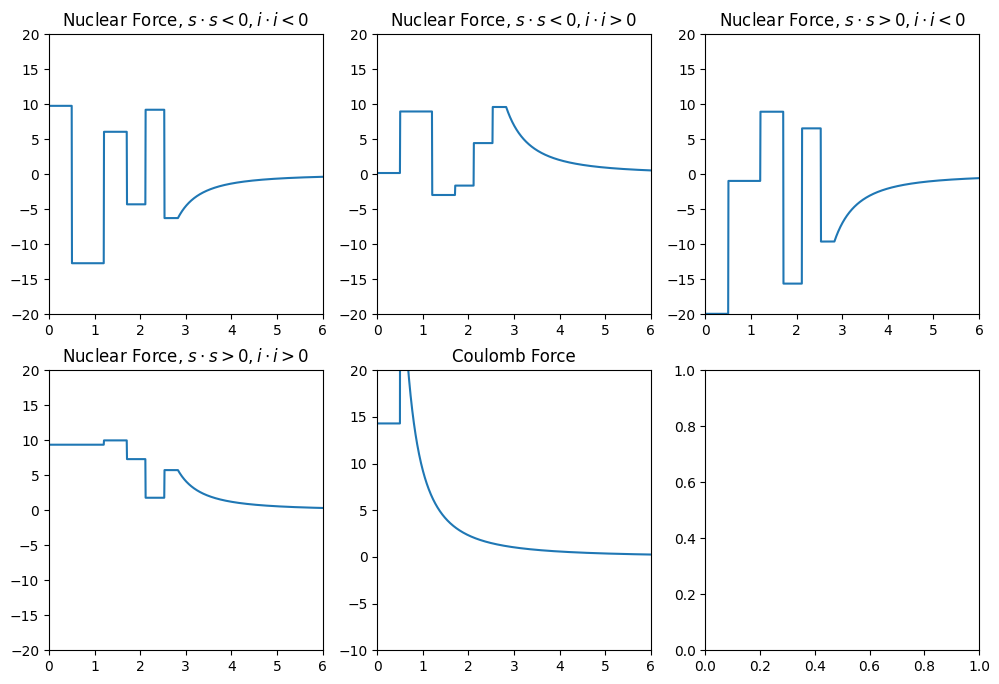

In [4]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

x = np.linspace(0, 6, 1000)

y_lim = (-20, 20)
y_lim_c = (-10, 20)

axs[0,0].plot(x, [f_nuclear_mm(_) for _ in x])
axs[0,0].set_ylim(*y_lim)
axs[0,0].set_xlim(0, 6)
axs[0,0].set_title("Nuclear Force, $s \cdot s < 0, i \cdot i < 0$")

axs[0,1].plot(x, [f_nuclear_mp(_) for _ in x])
axs[0,1].set_ylim(*y_lim)
axs[0,1].set_xlim(0, 6)
axs[0,1].set_title("Nuclear Force, $s \cdot s < 0, i \cdot i > 0$")

axs[0,2].plot(x, [f_nuclear_pm(_) for _ in x])
axs[0,2].set_ylim(*y_lim)
axs[0,2].set_xlim(0, 6)
axs[0,2].set_title("Nuclear Force, $s \cdot s > 0, i \cdot i < 0$")

axs[1,0].plot(x, [f_nuclear_pp(_) for _ in x])
axs[1,0].set_ylim(*y_lim)
axs[1,0].set_xlim(0, 6)
axs[1,0].set_title("Nuclear Force, $s \cdot s > 0, i \cdot i > 0$")

axs[1,1].plot(x, [f_coulomb(_) for _ in x])
axs[1,1].set_ylim(*y_lim_c)
axs[1,1].set_xlim(0, 6)
axs[1,1].set_title("Coulomb Force")

In [9]:
lat = lattice.NuclearLattice(N=12, Z = 11, lattice_width=13, state_space_dim=3)

In [19]:
lat.step(f_full)

tensor(-210.3258, dtype=torch.float64)

In [23]:
lat.E_tot(f_full) / (12 + 11)

tensor(-9.1446, dtype=torch.float64)